## Models of number perception, and probability perception, with plots

## Probability weighting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math


from platform import python_version
print('python ' + python_version())

def weight(p, beta):
    """ probability weighting function: convert probability p to weight """
    if p == 0:
        return 0 
    return np.exp( -1 * abs(np.log(p))**beta )

python 3.8.16


# Probability weighting function

$p = exp(-1 (- \log(p))^\beta)$

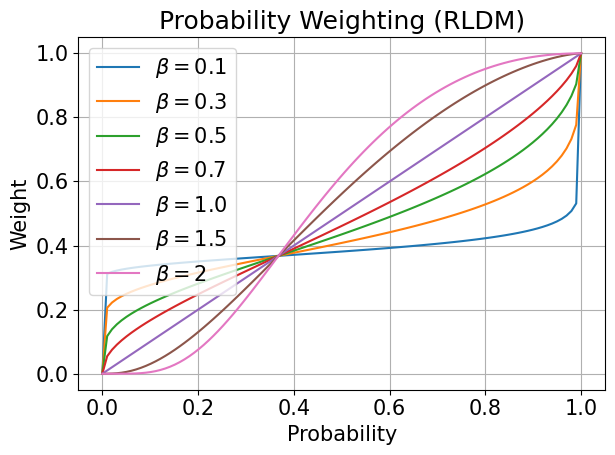

In [77]:
# --------------------------------------------
# plot Probability Weighting
# --------------------------------------------
plt.rcParams.update({'font.size': 15})
plt.grid('grey', zorder=0)
x = np.linspace(0, 1, 100)
betas = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2]

for b in betas:
   weights = [weight(p, b) for p in x]
   plt.plot(x, weights, label=fr'$\beta = {round(b, 2)}$', zorder=3)
    
plt.title('Probability Weighting (RLDM)')
plt.ylabel('Weight')
plt.xlabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

# Information theoretic model from Cheyenne & Piantodosi 2020

In [3]:
import scipy.stats as st

def KL(p,q):
	#KL divergence with prior p and posterior q
	return np.sum(q * (np.log2(q) - np.log2(p)), axis=1)


def compute_q_nk(ns, ks, p_n,p_k, lam, sm=1e-10):
	#computing the posterior Q for a given lambda
    lam = lam.reshape((len(lam),1))
    p_n = p_n.reshape((len(p_n),1))

    q_nk = -((p_n * (ns-ks)**2.)/(lam)) 


    q_nk = np.exp(q_nk)
    q_nk = q_nk * p_k 
    
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)
    
    # prevent zeros in q_nk; if these two lines are commented, there will be NaNs
    q_nk += sm
    q_nk = q_nk/ np.sum(q_nk, axis=1).reshape(len(q_nk), 1)



    return q_nk


def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)

    ents = KL(p_k, q_nk)

    for i in range(n_steps):

        diffs = ents - info_bound
        deltas = diffs *0.025

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1))

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk




# probability of a number a
def P(x,a):
	p = 1./(x**a)

	return p/np.sum(p)

def find_q_nk(ns,ks,p_n,p_k,info_bound, n_steps=1500):
	#uses gradient descent to find lambdas that
	#get KL(Q||P) as close to the bound "info_bound" as possible

    lams = np.ones_like(ns)*0.5                  # this is an array of 0.5, for each n (e.g. length 15)
    q_nk = compute_q_nk( ns, ks, p_n,p_k, lams)  # initial q(k|n)

    ents = KL(p_k, q_nk) # KL divergence measures how many bits of information between p and q

    # here is gradient descent
    for i in range(n_steps):

        # lambda scales KL divergence in the Lagrange multipliers equation 
        # but it also figures in the Q(k|n) --- bigger lambda - smaller Q
        diffs = ents - info_bound
        deltas = diffs *0.025  

        lams = np.exp(np.log(lams) + deltas.reshape(len(deltas),1)) 

        q_nk = compute_q_nk(ns,ks,p_n,p_k,lams)
        ents = KL(p_k,q_nk)

    return q_nk

step_n = 1
step_k = 1

#prior parameter, we use alpha = 2
alpha = 2

#range of n and k
min_n = 1
max_n = 15
min_k = step_k
max_k = 25

ks = np.arange(min_k,max_k,step_k)   
ns = np.arange(min_n,max_n+1,step_n) 
ns = ns.reshape((len(ns),1))

# use power law 1/n^2 to calculate probabilities of each number, then make them add up to 1
p_ks = P(ks,float(alpha))   
p_ns = P(ns,float(alpha))

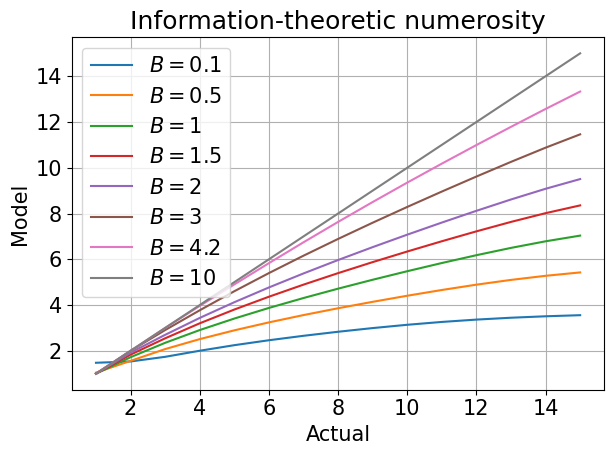

In [4]:
plt.rcParams.update({'font.size': 15})
plt.grid('grey', zorder=0)

# bits per time unit, information processing capacity
Bs = [0.1, 0.5, 1, 1.5, 2, 3, 4.2, 10]

for info_bound in Bs:
    # gradient descent for method of lagrangian multipliers
    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)

    mean_k = [] # given Q, calculate mean k for each n
    
    for n in range(len(Q)) :
        q_kn = Q[n]
        mean_k.append(sum(q_kn*ks)) #  expectation
     
    plt.plot(ns, mean_k, label=fr'$B = {info_bound}$', zorder=3)  

plt.title('Information-theoretic numerosity')
plt.ylabel('Model')
plt.xlabel('Actual')
plt.legend()
plt.tight_layout()
plt.show()

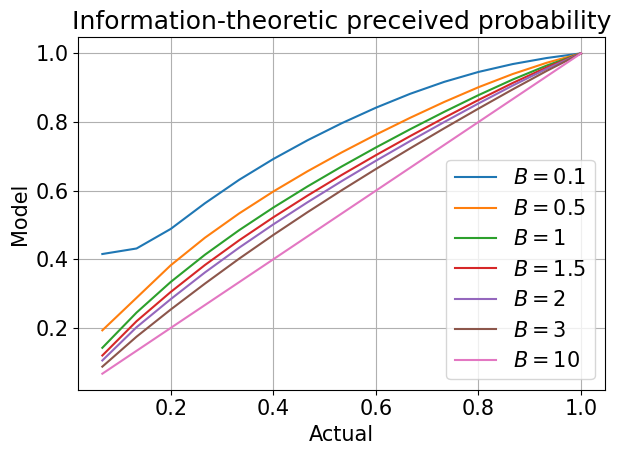

In [5]:
# test
# given 15 dark cells in a maze total, show the probability of exit in a room with n cells

plt.rcParams.update({'font.size': 15})
plt.grid('grey', zorder=0)

#geomspece
cells = np.linspace(1, 10, 10)
cells_total = 10
ns = np.arange(1, 16, 1) # 1..15
ns = ns.reshape((len(ns),1))
p_ns = P(ns,float(2))

Bs = [0.1, 0.5, 1, 1.5, 2, 3, 10]

for info_bound in Bs:
    # gradient descent for method of lagrangian multipliers
    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)
    mean_k = [] # given Q, calculate mean k for each n
    
    for n in range(len(Q)) :
        q_kn = Q[n]
        mean_k.append(sum(q_kn*ks)) #  expectation
    
    mean_k15 = sum(Q[14]*ks) # indexing starts with 0, so Q[14] is the 15th element
    plt.plot(ns/15, mean_k/mean_k15, label=fr'$B = {info_bound}$', zorder=3) 
    
plt.title('Information-theoretic preceived probability')
plt.ylabel('Model')
plt.xlabel('Actual')
plt.legend()
plt.tight_layout()
plt.show()

# Fitting information threshold parameter to subjects in MST


Generate Generate Q(k|n) for each R

Compute expectation for $n \in [1, 20]$ and $R \in [0.5, 5]$

Save this (n x R) table as pickle


In [57]:
Bs = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.6, 4.2, 5, 6, 10]
print(Bs)
ns = np.arange(1, 50, 1) 
ns = ns.reshape((len(ns),1))
ks = np.arange(1,80,1)   
p_ks = P(ks,float(2))  # use power law 1/n^2 to calculate probabilities, then make them add up to 1
p_ns = P(ns,float(2))

table = {}


for info_bound in Bs:
    
    Q = find_q_nk(ns,ks,p_ns,p_ks,info_bound)
    mean_k = {} # given Q, calculate mean k for each n
    
    for n in range(len(Q)) :
        q_kn = Q[n]
        mean_k[n+1] = sum(q_kn*ks) 
     
    table[info_bound] = mean_k
    


[0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.6, 4.2, 5, 6, 10]


In [58]:
# save to file
import os
import pickle
print(os.getcwd())

with open( os.getcwd() + 'Q_k_n.pickle', 'wb') as handle:
            pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# print(table[0.1]) # acess all n-k for info bound 0.1

/Users/mk/Desktop/PlanningProject/essie_code_python_and_experiment/prospect_theory_thesis


In [55]:
# test
# making sure perceived and actual numbers converge at bits = 10 
print(table[10][1])
print(table[10][5])
print(table[10][10])
print(table[10][49])

print(table[6][1])
print(table[6][5])
print(table[6][10])
print(table[6][49])

1.000000308099997
5.000000276499998
10.000000237000025
48.96510354763048
1.000000308099997
5.000000276499998
9.926574101180309
43.86520186684508
